In [1]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.insert(0, parent_dir)

from utilities.gan_plotting import extensive_plotting
from utilities.backtesting_plots import backtest_var_single_asset
from utilities.gan_plotting import load_generated_returns
from backtesting.perform_var_tests import perform_var_backtesting_tests
from backtesting.perform_distribution_tests import perform_distribution_tests
from utilities.gan_plotting import create_rolling_empirical


In [2]:
parent_dir

'c:\\Users\\nicka\\master-thesis'

In [3]:
def fetch_data_df():
    # Load the data
    df = pd.read_csv('../../data/final_daily_returns_asset_classes.csv', index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index)
    start_test_date = os.getenv("START_TEST_DATE")
    
    if start_test_date is None:
        raise ValueError("Environment variable 'START_TEST_DATE' is not set.")

    start_test_date = pd.to_datetime(start_test_date)

    columns = [0,1,2,4, 5, 6]
    selected_columns = df.iloc[:, columns]  # Remember: Python uses 0-based indexing

    pre_test_df = selected_columns[selected_columns.index < start_test_date]
    test_df = selected_columns[selected_columns.index >= start_test_date].iloc[:252]
    
    return pre_test_df, test_df

returns_df, test_returns_df = fetch_data_df()

returns_df.head()

,REEL,PE,MSCIWORLD,GOV,HY,EONIA
Date,,,,,,
2005-10-11,0.003231,0.006833,0.004578,-0.001916,-0.004075,0.000054
2005-10-12,-0.003550,-0.009657,-0.007867,-0.001570,-0.004370,0.000058
2005-10-13,-0.018599,-0.010692,0.000588,-0.003062,-0.003423,0.000058
2005-10-14,-0.007856,0.001569,-0.002991,0.000060,0.001618,0.000058
2005-10-17,-0.003613,0.000492,0.003290,-0.000227,0.005447,0.000173


Yield curves data preview:


,TIME_PERIOD,SR_1Y,SR_2Y,SR_3Y,SR_4Y,SR_5Y,SR_6Y,SR_7Y,SR_8Y,SR_9Y,SR_10Y
0,2004-09-06,2.298838,2.641262,2.951578,3.223235,3.457222,3.657429,3.828505,3.974939,4.100712,4.209220
1,2004-09-07,2.328891,2.679766,2.987293,3.252486,3.479518,3.673463,3.839294,3.981472,4.103839,4.209626
2,2004-09-08,2.346666,2.706542,3.016998,3.282196,3.507894,3.699959,3.863753,4.003922,4.124390,4.228419
3,2004-09-09,2.308988,2.646224,2.945649,3.206136,3.430628,3.623456,3.789113,3.931745,4.054972,4.161872
4,2004-09-10,2.271566,2.589654,2.884699,3.146724,3.374729,3.571385,3.740559,3.886214,4.011975,4.120981



Yield curve with extracted features:


,SR_1Y,SR_2Y,SR_3Y,SR_4Y,SR_5Y,SR_6Y,SR_7Y,SR_8Y,SR_9Y,SR_10Y,level,slope,curvature
TIME_PERIOD,,,,,,,,,,,,,
2004-09-06,2.298838,2.641262,2.951578,3.223235,3.457222,3.657429,3.828505,3.974939,4.100712,4.209220,3.434294,1.910381,0.406386
2004-09-07,2.328891,2.679766,2.987293,3.252486,3.479518,3.673463,3.839294,3.981472,4.103839,4.209626,3.453565,1.880735,0.420518
2004-09-08,2.346666,2.706542,3.016998,3.282196,3.507894,3.699959,3.863753,4.003922,4.124390,4.228419,3.478074,1.881753,0.440703
2004-09-09,2.308988,2.646224,2.945649,3.206136,3.430628,3.623456,3.789113,3.931745,4.054972,4.161872,3.409878,1.852884,0.390396
2004-09-10,2.271566,2.589654,2.884699,3.146724,3.374729,3.571385,3.740559,3.886214,4.011975,4.120981,3.359849,1.849416,0.356911



Combined data (yield features and PCA):


,SR_1Y,SR_2Y,SR_3Y,SR_4Y,SR_5Y,SR_6Y,SR_7Y,SR_8Y,SR_9Y,SR_10Y,level,slope,curvature,PCA1,PCA2
date,,,,,,,,,,,,,,,
2005-05-16,2.082030,2.218426,2.386329,2.562410,2.733366,2.892191,3.035757,3.163243,3.275141,3.372632,2.772152,1.290601,0.012071,0.001054,-0.000278
2005-05-17,2.080557,2.218323,2.387596,2.565011,2.737237,2.897253,3.041923,3.170423,3.283247,3.381578,2.776315,1.301021,0.012338,0.001057,-0.000269
2005-05-18,2.075582,2.210477,2.376074,2.549497,2.717710,2.873864,3.014909,3.140066,3.249837,3.345400,2.755342,1.269818,0.014437,0.001059,-0.000266
2005-05-19,2.081787,2.220725,2.388781,2.563513,2.732218,2.888297,3.028887,3.153343,3.262268,3.356907,2.767672,1.275120,0.025743,0.001061,-0.000261
2005-05-20,2.103109,2.258006,2.433233,2.610300,2.778832,2.933568,3.072390,3.195043,3.302317,3.395530,2.808233,1.292421,0.059024,0.001064,-0.000253


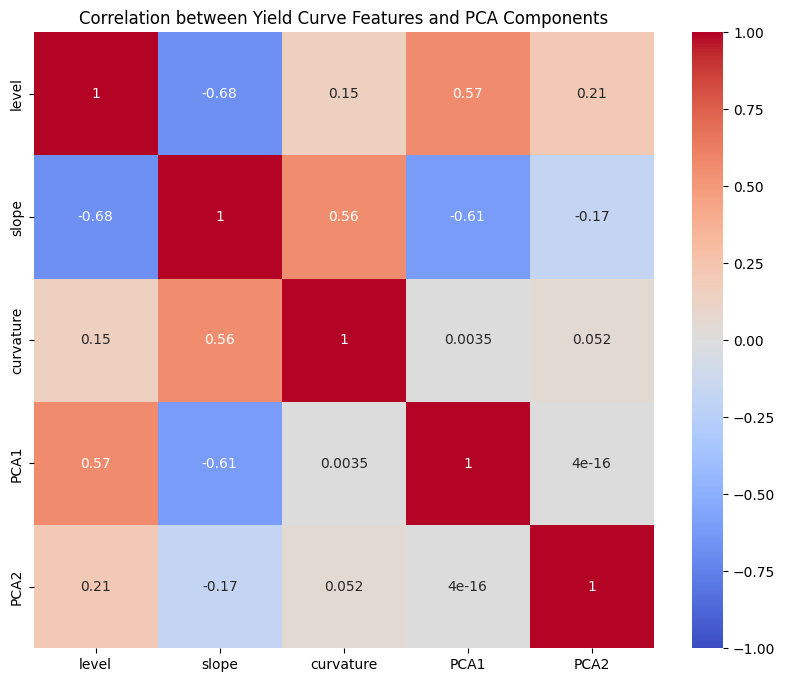

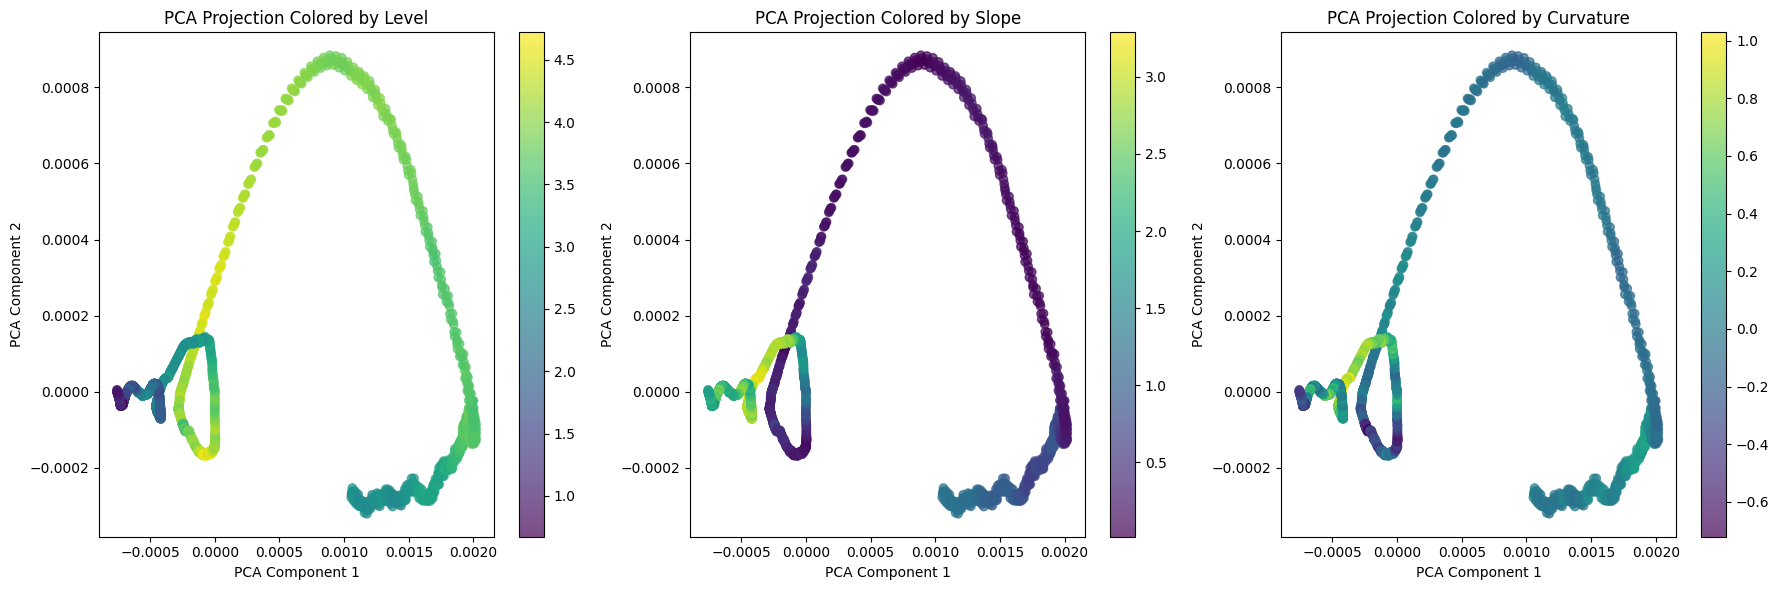

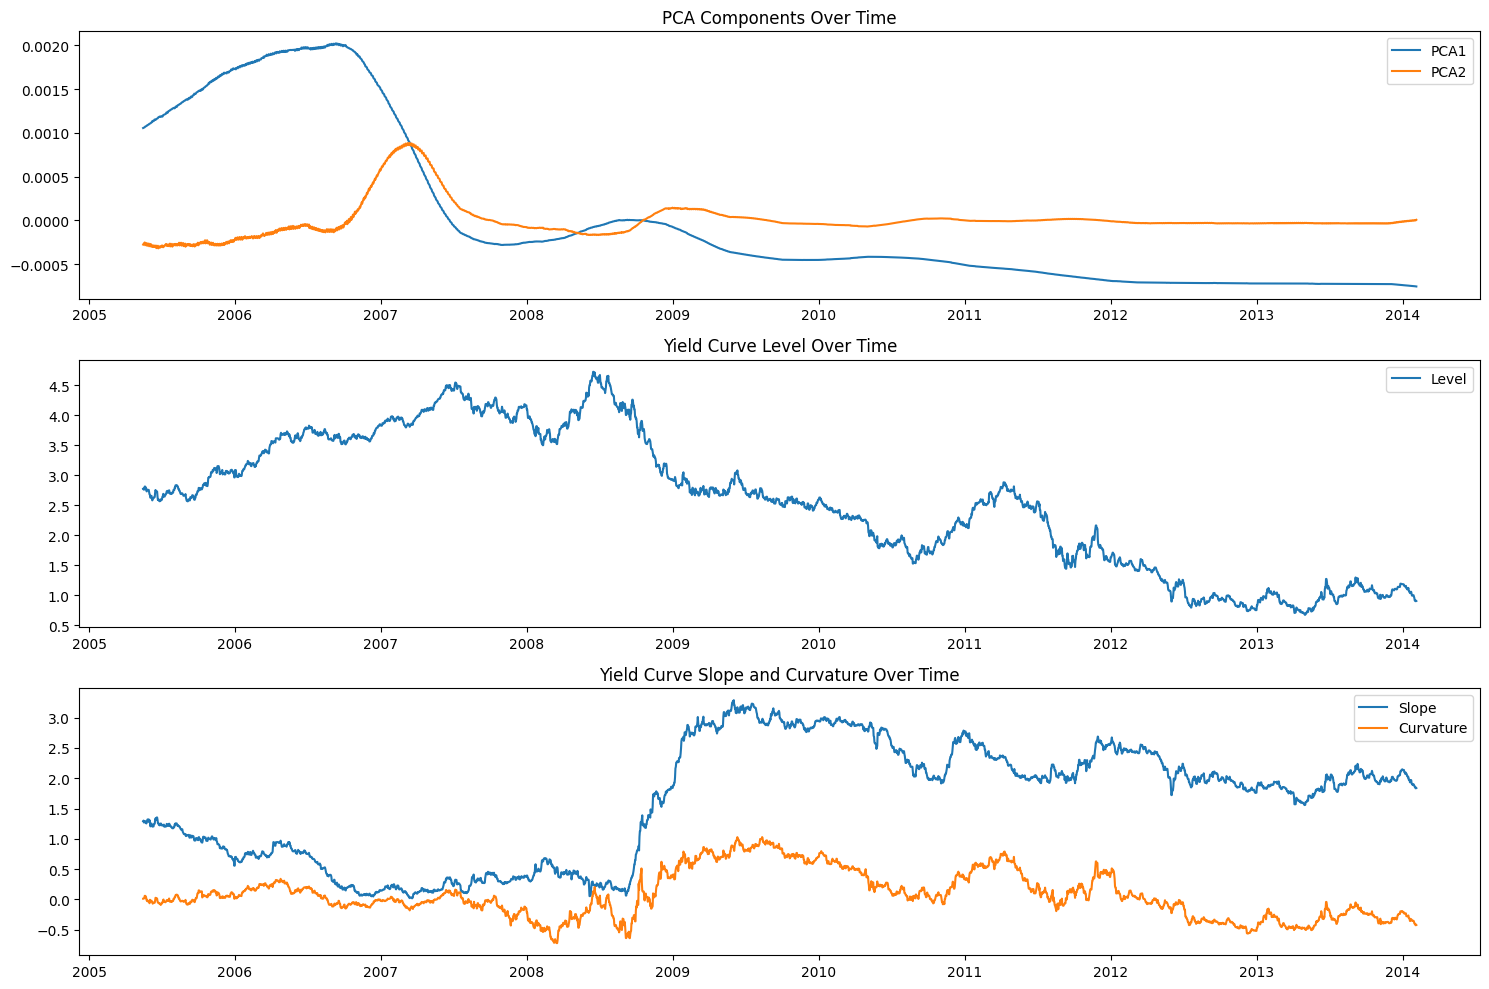

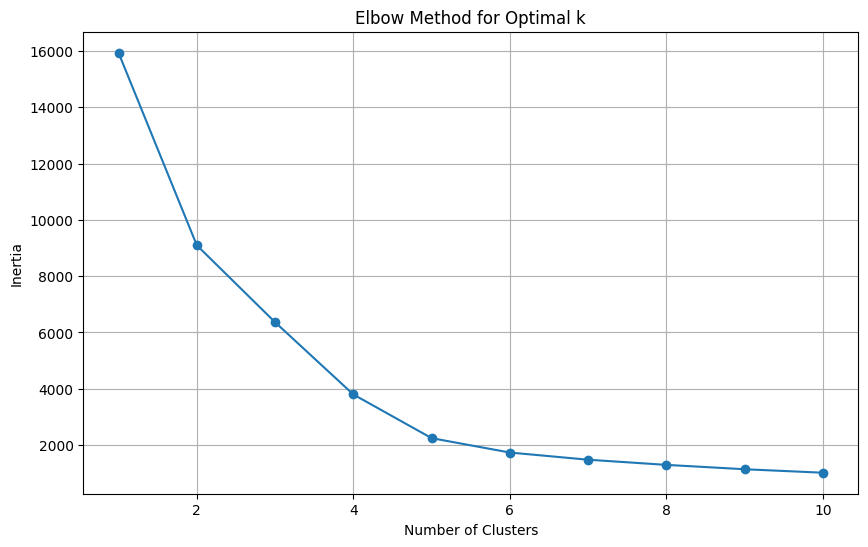

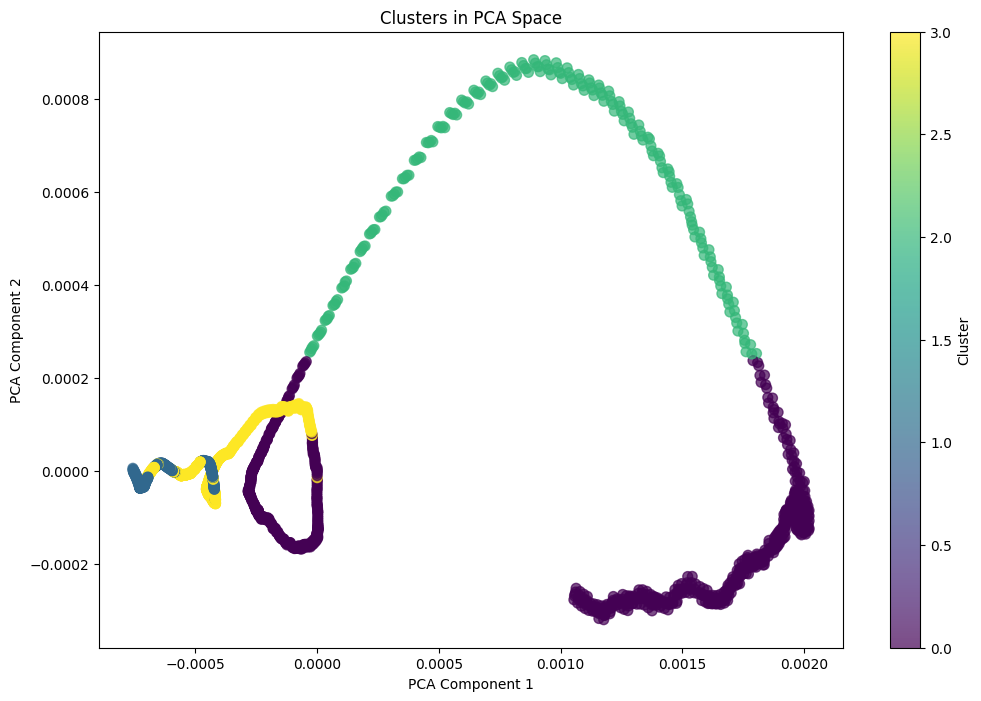


Cluster centers:


,PCA1,PCA2,level,slope,curvature
cluster,,,,,
0,0.000814,-0.000117,3.621389,0.612768,-0.067850
1,-0.000670,-0.000021,1.252708,2.045575,-0.179604
2,0.000895,0.000625,3.982521,0.153297,-0.029691
3,-0.000421,0.000009,2.496948,2.662290,0.578244


<Figure size 1400x800 with 0 Axes>

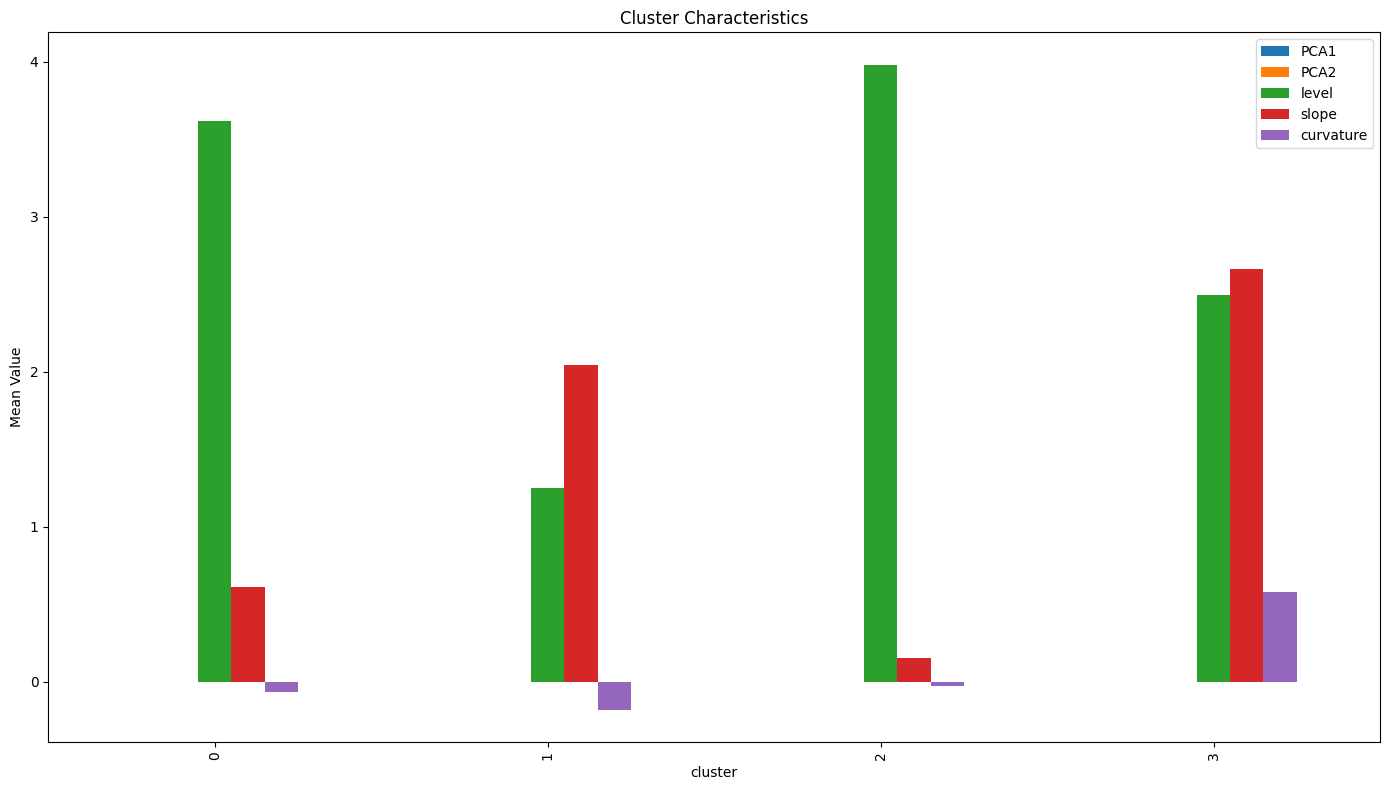

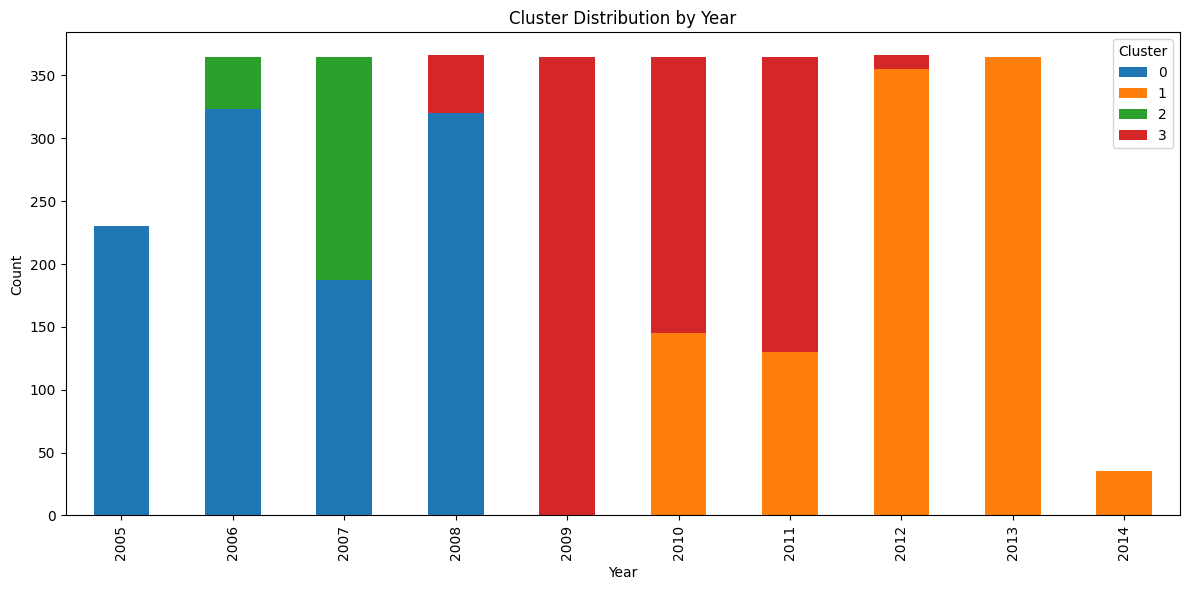

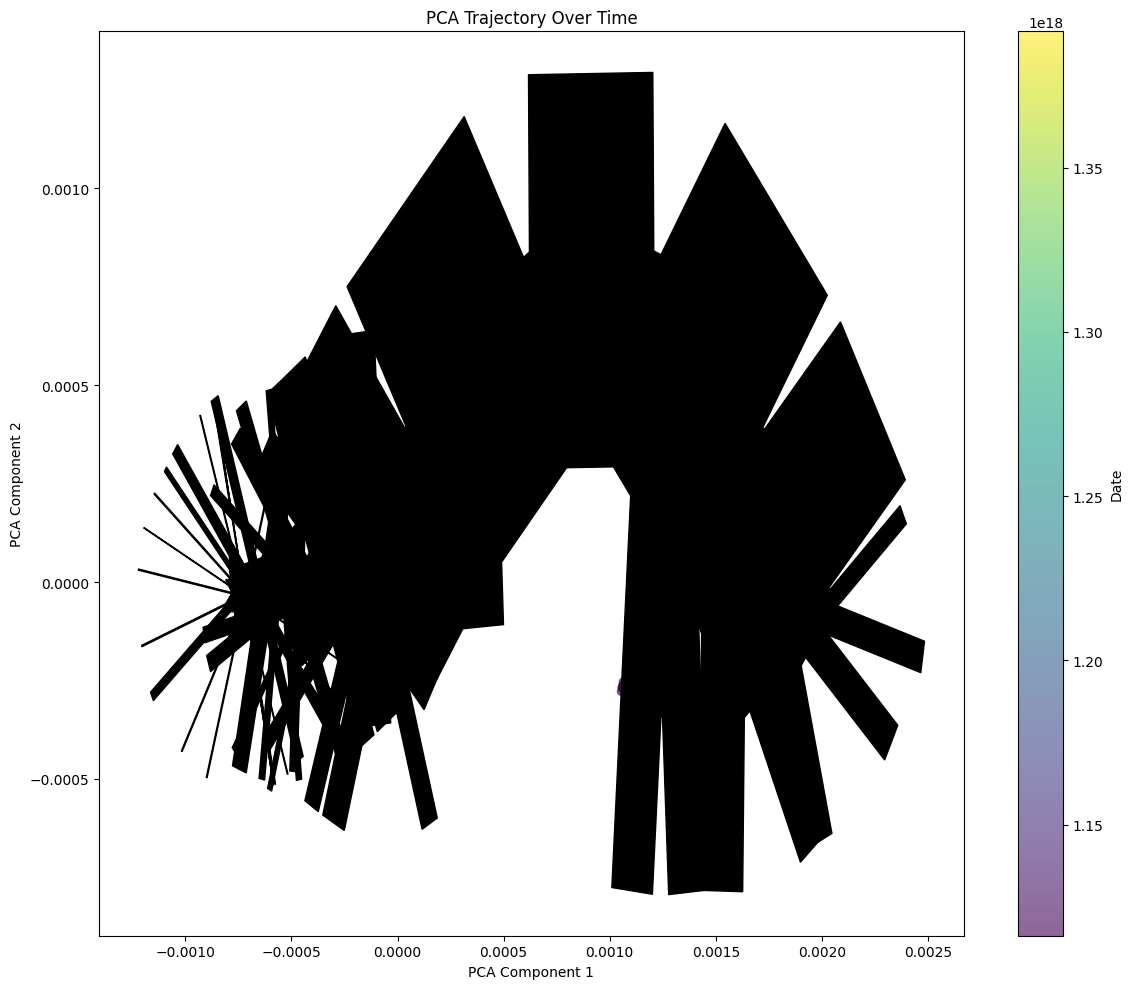

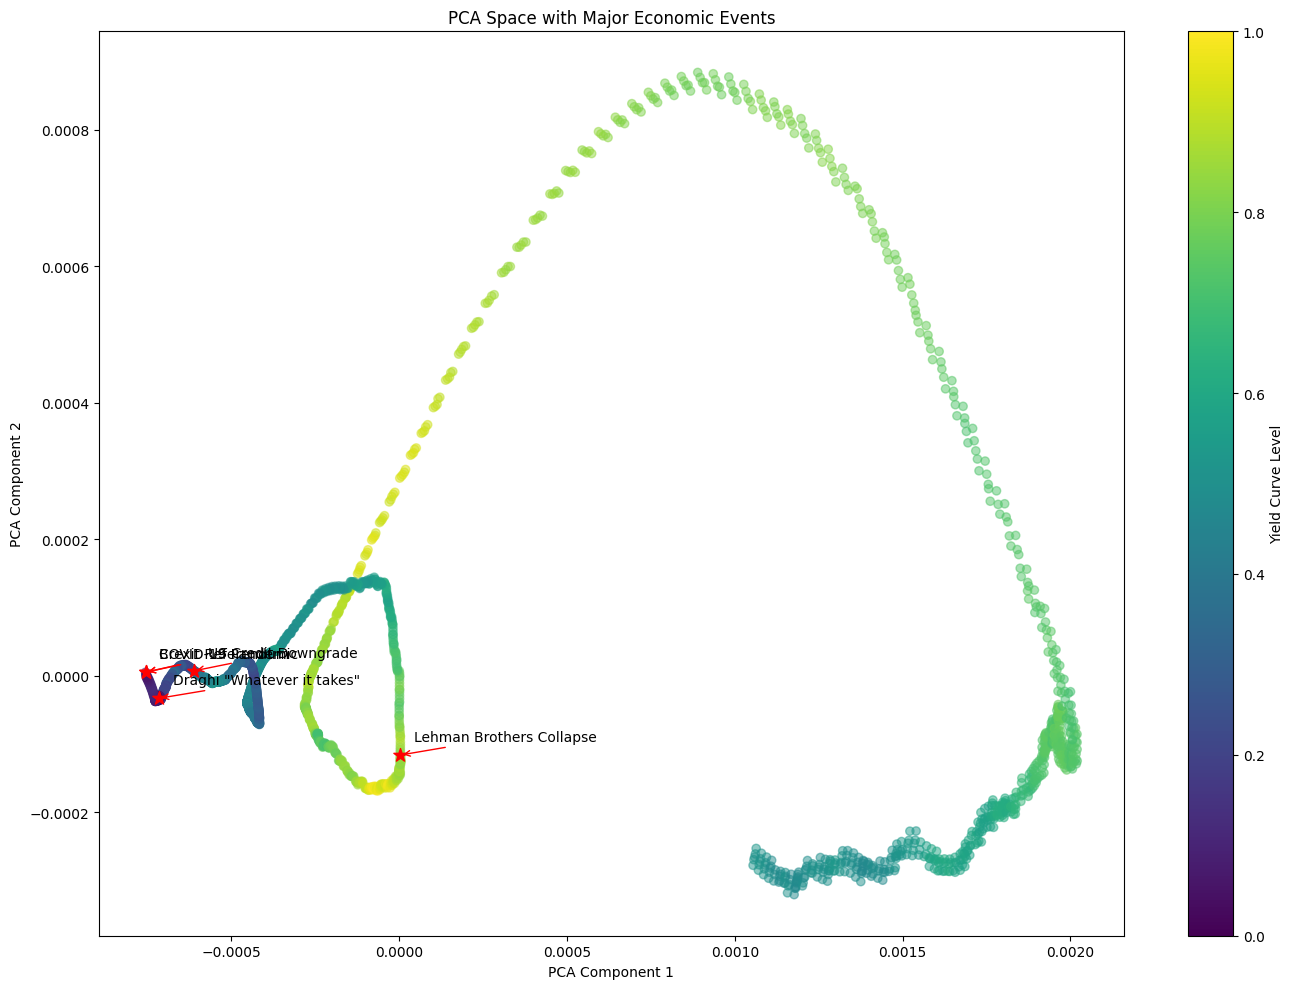

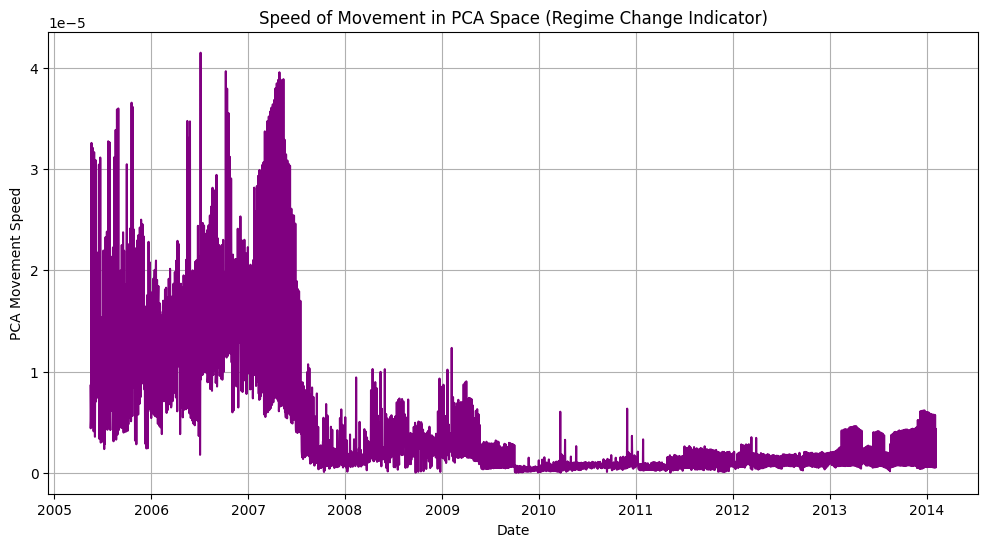

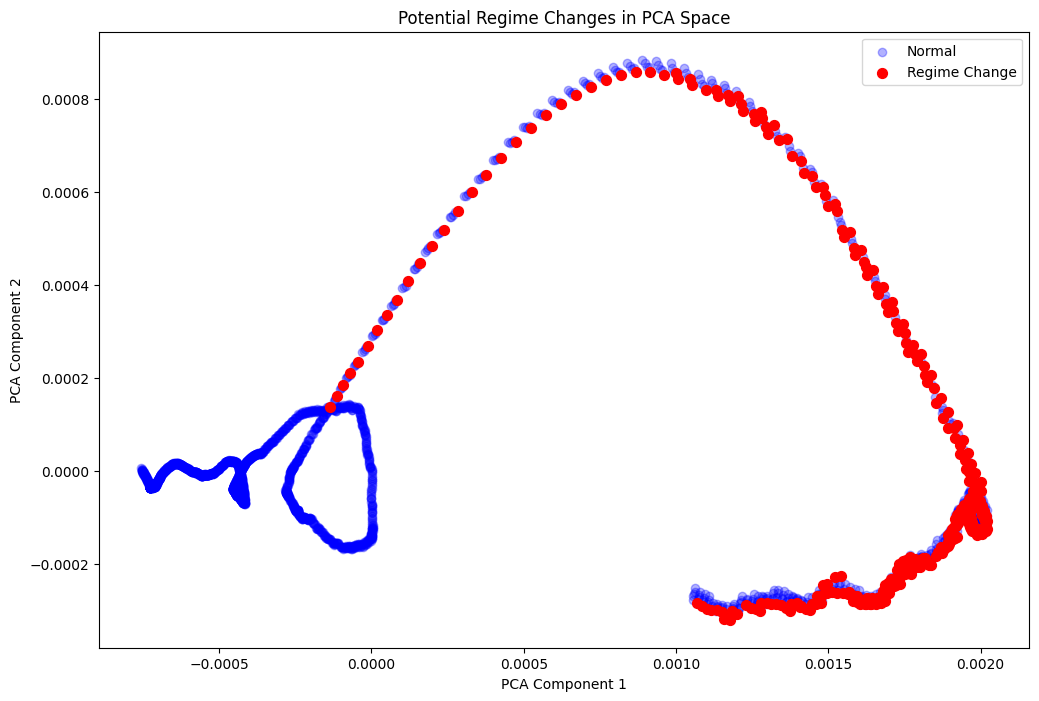

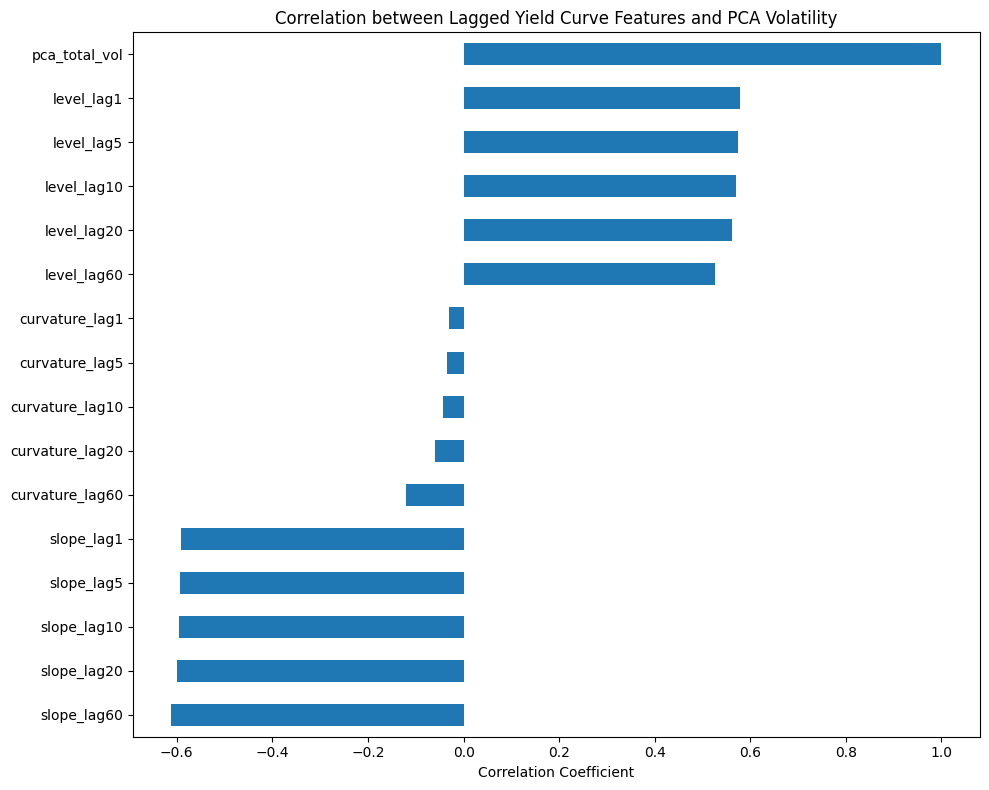


Volatility Prediction Results:
R-squared: 1.0000
RMSE: 0.000000

Feature Importance:
pca_total_vol: 1.000000
slope_lag60: 0.000000
slope_lag20: -0.000000
slope_lag10: -0.000000
slope_lag5: 0.000000


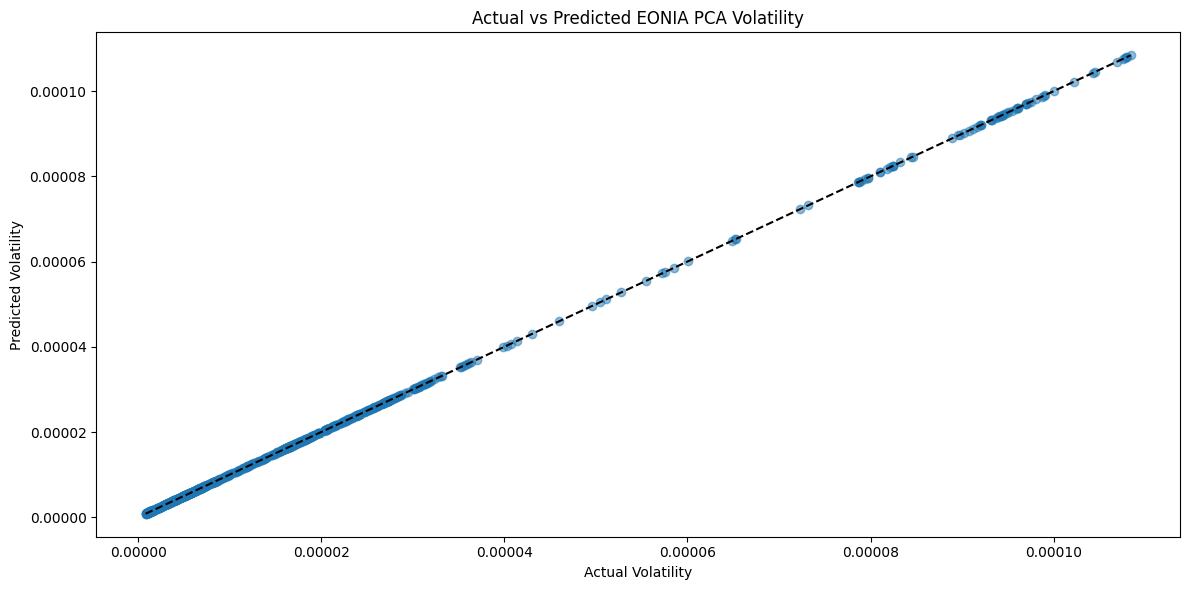


Summary of Yield Curve and EONIA PCA Relationship:
Number of observations: 3187
Number of detected clusters: 4
Strongest correlation between yield feature and PCA: 0.6112
Best predictability of EONIA volatility from yield features (R²): 1.0000

Periods of strongest yield curve influence on EONIA behavior:


Timestamp('2005-05-16 00:00:00')

Timestamp('2007-04-23 00:00:00')


Analysis complete. You can now examine the specific patterns between your yield curves and EONIA returns.


In [4]:
# Yield Curve and EONIA PCA Analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.cluster import KMeans

# If needed, install required packages
# !pip install pandas numpy matplotlib scikit-learn seaborn

## 1. Load your data

# Load yield curves data
yield_curves = pd.read_csv("../../data/yield_curves.csv")

# Preview the data
print("Yield curves data preview:")
display(yield_curves.head())

# Convert TIME_PERIOD to datetime and set as index
yield_curves['TIME_PERIOD'] = pd.to_datetime(yield_curves['TIME_PERIOD'])
yield_curves.set_index('TIME_PERIOD', inplace=True)

# Calculate yield curve features
yield_columns = [col for col in yield_curves.columns if col.startswith('SR_')]
yield_curves['level'] = yield_curves[yield_columns].mean(axis=1)
yield_curves['slope'] = yield_curves['SR_10Y'] - yield_curves['SR_1Y']
yield_curves['curvature'] = 2 * yield_curves['SR_5Y'] - yield_curves['SR_10Y'] - yield_curves['SR_1Y']

print("\nYield curve with extracted features:")
display(yield_curves.head())

## 2. Load or recreate your PCA results

# Option 1: Use your pre-computed PCA results
# Uncomment and modify this section based on your data

# Define function to create rolling empirical returns (as in your code)
def create_rolling_empirical(returns_series, window_size=252):
    rolling_data = []
    for i in range(len(returns_series) - window_size):
        window = returns_series[i : i + window_size]
        rolling_data.append(window)
    return np.array(rolling_data)

# Create rolling returns
eonia_returns = returns_df['EONIA'].values
real_returns = create_rolling_empirical(eonia_returns)
real_returns = np.nan_to_num(real_returns, nan=np.nanmedian(real_returns))

# Apply PCA
pca = PCA(n_components=2)
real_pca = pca.fit_transform(real_returns)
'''

# Option 2: For demonstration, create dummy PCA results if needed
# In your actual notebook, replace this with your real PCA results
np.random.seed(42)  # For reproducibility
dummy_data_length = len(yield_curves) - 252  # Adjust based on your rolling window
real_pca = np.random.randn(dummy_data_length, 2) * 0.001

# Visualize PCA results
plt.figure(figsize=(10, 8))
plt.scatter(real_pca[:, 0], real_pca[:, 1], color="blue", alpha=0.5)
plt.title("PCA Projection of EONIA Rolling Returns")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()"
'''

## 3. Align yield curves with PCA results

# Create a date range for PCA results
# This assumes your returns data starts at the same time as yield curves
start_date = yield_curves.index.min()
pca_dates = [start_date + timedelta(days=i + 252) for i in range(len(real_pca))]

# Create DataFrame with PCA results
pca_df = pd.DataFrame({
    'PCA1': real_pca[:, 0],
    'PCA2': real_pca[:, 1],
    'date': pca_dates
})
pca_df.set_index('date', inplace=True)

# Align with yield curves
aligned_yield = yield_curves.reindex(pca_df.index, method='nearest')

# Combine datasets
combined_data = pd.concat([aligned_yield, pca_df], axis=1)

print("\nCombined data (yield features and PCA):")
display(combined_data.head())

## 4. Analyze correlation between yield curve features and PCA components

# Calculate correlation
features = ['level', 'slope', 'curvature', 'PCA1', 'PCA2']
corr = combined_data[features].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between Yield Curve Features and PCA Components')
plt.show()

## 5. Visualize PCA colored by yield curve features

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
features = ['level', 'slope', 'curvature']

for i, feature in enumerate(features):
    sc = axes[i].scatter(
        combined_data['PCA1'], 
        combined_data['PCA2'], 
        c=combined_data[feature], 
        cmap='viridis', 
        alpha=0.7
    )
    axes[i].set_title(f'PCA Projection Colored by {feature.capitalize()}')
    axes[i].set_xlabel('PCA Component 1')
    axes[i].set_ylabel('PCA Component 2')
    fig.colorbar(sc, ax=axes[i])

plt.tight_layout()
plt.show()

## 6. Time series analysis

plt.figure(figsize=(15, 10))

# Plot time series of PCA components
plt.subplot(3, 1, 1)
plt.plot(combined_data.index, combined_data['PCA1'], label='PCA1')
plt.plot(combined_data.index, combined_data['PCA2'], label='PCA2')
plt.title('PCA Components Over Time')
plt.legend()

# Plot yield curve features
plt.subplot(3, 1, 2)
plt.plot(combined_data.index, combined_data['level'], label='Level')
plt.title('Yield Curve Level Over Time')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(combined_data.index, combined_data['slope'], label='Slope')
plt.plot(combined_data.index, combined_data['curvature'], label='Curvature')
plt.title('Yield Curve Slope and Curvature Over Time')
plt.legend()

plt.tight_layout()
plt.show()

## 7. Clustering analysis

# Prepare data for clustering
cluster_features = ['PCA1', 'PCA2', 'level', 'slope', 'curvature']
X = combined_data[cluster_features].copy()

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal number of clusters using elbow method
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

# Choose k based on elbow curve
k = 4  # Adjust based on your elbow curve
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to the data
combined_data['cluster'] = clusters

# Visualize clusters on PCA projection
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    combined_data['PCA1'], 
    combined_data['PCA2'], 
    c=combined_data['cluster'], 
    cmap='viridis', 
    alpha=0.7,
    s=50
)
plt.colorbar(scatter, label='Cluster')
plt.title('Clusters in PCA Space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Analyze cluster characteristics
cluster_stats = combined_data.groupby('cluster')[cluster_features].mean()
print("\nCluster centers:")
display(cluster_stats)

# Visualize cluster characteristics
plt.figure(figsize=(14, 8))
cluster_stats.plot(kind='bar', figsize=(14, 8))
plt.title('Cluster Characteristics')
plt.ylabel('Mean Value')
plt.tight_layout()
plt.show()

## 8. Time pattern analysis

# Add year and month columns
combined_data['year'] = combined_data.index.year
combined_data['month'] = combined_data.index.month

# Count clusters by year
yearly_clusters = pd.crosstab(combined_data['year'], combined_data['cluster'])
yearly_clusters.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Cluster Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# Plot the trajectory over time with arrows
plt.figure(figsize=(12, 10))

# Sort by date to ensure proper time sequence
sorted_data = combined_data.sort_index()

# Plot points
plt.scatter(sorted_data['PCA1'], sorted_data['PCA2'], 
            c=sorted_data.index, cmap='viridis', 
            alpha=0.6, s=30)

# Add arrows to show trajectory (plot every n points to avoid cluttering)
n = max(1, len(sorted_data) // 50)  # Show ~50 arrows
for i in range(0, len(sorted_data) - n, n):
    plt.arrow(sorted_data['PCA1'].iloc[i], sorted_data['PCA2'].iloc[i],
             sorted_data['PCA1'].iloc[i+n] - sorted_data['PCA1'].iloc[i],
             sorted_data['PCA2'].iloc[i+n] - sorted_data['PCA2'].iloc[i],
             head_width=0.0001, head_length=0.0001, fc='black', ec='black')

plt.colorbar(label='Date')
plt.title('PCA Trajectory Over Time')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.tight_layout()
plt.show()

## 9. Mark important economic events

# Define important economic events (adjust dates based on your data period)
events = [
    # Example events - replace with actual dates and events relevant to your data period
    ['2008-09-15', 'Lehman Brothers Collapse'],
    ['2011-08-05', 'US Credit Downgrade'],
    ['2012-07-26', 'Draghi "Whatever it takes"'],
    ['2016-06-23', 'Brexit Referendum'],
    ['2020-03-11', 'COVID-19 Pandemic']
]

# Convert to DataFrame
events_df = pd.DataFrame(events, columns=['date', 'event'])
events_df['date'] = pd.to_datetime(events_df['date'])

# Find closest data points to events
for i, event in events_df.iterrows():
    try:
        if event['date'] in combined_data.index:
            idx = combined_data.index.get_loc(event['date'])
        else:
            # Find closest date
            idx = combined_data.index.get_indexer([event['date']], method='nearest')[0]
        
        events_df.loc[i, 'pca1'] = combined_data['PCA1'].iloc[idx]
        events_df.loc[i, 'pca2'] = combined_data['PCA2'].iloc[idx]
    except:
        # Skip if event is outside data range
        print(f"Event {event['event']} on {event['date']} is outside data range")

# Plot PCA with events marked
plt.figure(figsize=(14, 10))

# Plot the main PCA scatter
plt.scatter(combined_data['PCA1'], combined_data['PCA2'], 
            alpha=0.5, c=combined_data['level'], cmap='viridis')

# Mark events
for i, event in events_df.iterrows():
    if 'pca1' in event and not pd.isna(event['pca1']):
        plt.scatter(event['pca1'], event['pca2'], c='red', s=100, marker='*')
        plt.annotate(event['event'], 
                    (event['pca1'], event['pca2']),
                    xytext=(10, 10),
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', color='red'))

plt.title('PCA Space with Major Economic Events')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Yield Curve Level')
plt.tight_layout()
plt.show()

# Save the complete analysis results
combined_data.to_csv('combined_analysis_results.csv')

## 10. Advanced Analysis: Regime Detection

# Calculate moving windows of the PCA data to detect regimes
window_size = 30  # 30-day window
combined_data['pca1_ma'] = combined_data['PCA1'].rolling(window=window_size).mean()
combined_data['pca2_ma'] = combined_data['PCA2'].rolling(window=window_size).mean()

# Calculate the velocity and acceleration of movement in PCA space
combined_data['pca1_velocity'] = combined_data['PCA1'].diff()
combined_data['pca2_velocity'] = combined_data['PCA2'].diff()
combined_data['pca_speed'] = np.sqrt(combined_data['pca1_velocity']**2 + combined_data['pca2_velocity']**2)

# Visualize the speed of movement in PCA space over time
plt.figure(figsize=(12, 6))
plt.plot(combined_data.index, combined_data['pca_speed'], color='purple')
plt.title('Speed of Movement in PCA Space (Regime Change Indicator)')
plt.xlabel('Date')
plt.ylabel('PCA Movement Speed')
plt.grid(True)
plt.show()

# Identify high-velocity periods (potential regime changes)
threshold = combined_data['pca_speed'].quantile(0.9)  # Top 10% of movements
regime_changes = combined_data[combined_data['pca_speed'] > threshold]

plt.figure(figsize=(12, 8))
plt.scatter(combined_data['PCA1'], combined_data['PCA2'], c='blue', alpha=0.3, label='Normal')
plt.scatter(regime_changes['PCA1'], regime_changes['PCA2'], c='red', s=50, label='Regime Change')
plt.title('Potential Regime Changes in PCA Space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

## 11. Relationship between yield curve features and future EONIA volatility

# Calculate the volatility of the PCA components
combined_data['pca1_vol'] = combined_data['PCA1'].rolling(window=30).std()
combined_data['pca2_vol'] = combined_data['PCA2'].rolling(window=30).std()
combined_data['pca_total_vol'] = np.sqrt(combined_data['pca1_vol']**2 + combined_data['pca2_vol']**2)

# Create lagged yield curve features to test predictive power
for lag in [1, 5, 10, 20, 60]:  # Different lag periods
    combined_data[f'level_lag{lag}'] = combined_data['level'].shift(lag)
    combined_data[f'slope_lag{lag}'] = combined_data['slope'].shift(lag)
    combined_data[f'curvature_lag{lag}'] = combined_data['curvature'].shift(lag)

# Analyze correlation between lagged yield curve features and volatility
lagged_features = [col for col in combined_data.columns if 'lag' in col]
vol_corr = combined_data[lagged_features + ['pca_total_vol']].corr()['pca_total_vol'].sort_values()

plt.figure(figsize=(10, 8))
vol_corr.plot(kind='barh')
plt.title('Correlation between Lagged Yield Curve Features and PCA Volatility')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

# Linear regression to predict volatility
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Prepare data for prediction (remove NaN values)
pred_data = combined_data.dropna()

# Select best features based on correlation analysis
best_features = vol_corr.abs().sort_values(ascending=False).index[:5].tolist()

X = pred_data[best_features]
y = pred_data['pca_total_vol']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nVolatility Prediction Results:")
print(f"R-squared: {r2:.4f}")
print(f"RMSE: {rmse:.6f}")
print("\nFeature Importance:")
for feature, coef in zip(best_features, model.coef_):
    print(f"{feature}: {coef:.6f}")

# Plot actual vs predicted volatility
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual Volatility')
plt.ylabel('Predicted Volatility')
plt.title('Actual vs Predicted EONIA PCA Volatility')
plt.tight_layout()
plt.show()

## 12. Conclusion: Patterns and Relationships Summary

# Print summary statistics
print("\nSummary of Yield Curve and EONIA PCA Relationship:")
print(f"Number of observations: {len(combined_data)}")
print(f"Number of detected clusters: {len(cluster_stats)}")
print(f"Strongest correlation between yield feature and PCA: {corr.iloc[:3, 3:].abs().max().max():.4f}")
print(f"Best predictability of EONIA volatility from yield features (R²): {r2:.4f}")

# Identify periods where yield curve shape most influences EONIA behavior
most_influential = combined_data[abs(combined_data['level'] * combined_data['PCA1']) > 
                               combined_data['level'].std() * combined_data['PCA1'].std() * 2]

print(f"\nPeriods of strongest yield curve influence on EONIA behavior:")
display(most_influential.index.min(), most_influential.index.max())

print("\nAnalysis complete. You can now examine the specific patterns between your yield curves and EONIA returns.")